# AutoEncoder on MBL

## Import packages

In [26]:
import numpy as np
import matplotlib.pyplot as plt

from math import factorial
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, add
from tensorflow.keras.layers import Layer, Dense, Dropout, Activation, Flatten, Reshape
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping



%matplotlib inline


## Load data

In [138]:

def load_eigs_npz(filename='data/results-L-12-W-1.0-seed-42.npz'):
    data = np.load(filename)
    eigvals = data[data.files[0]]
    eigvecs = data[data.files[1]]

    return eigvals, eigvecs.T

def listFilenames(Ls = [8],
                  ws = [1.0, 1.44, 1.89, 2.33, 2.78, 3.22, 3.67, 4.11, 4.56, 5.0, 
                          5.56, 6.11, 6.67, 7.22, 7.78, 8.33, 8.89, 9.44],
                   seeds = np.arange(0,20,1)):
    print('number of disorders',len(ws))
    print('number of seeds',len(seeds))
    print('L', Ls[0])
    Files = []
    for L in Ls:
        for w in ws:
            files = []
            for seed in seeds:
                file = 'data/results-L-{}-W-{}-seed-{}.npz'.format(L,w,seed)
                files.append(file)
            Files.append(files)
    return Files
    

def load_many_eigs(Files):  
    eigs = []
    for files in tqdm(Files):
        for file in files:
            eigvals, eigvecs = load_eigs_npz(file)
            data=eigvecs
            #data=eigvals
            eigs.append(data)
    print('Eigs Loaded!')
    eigs = np.array(eigs)
    return eigs
    


In [139]:
filenames = listFilenames(Ls=[10],
                          #ws=[1.0,1.44],
                         seeds = np.arange(0,60,1))
eigs = load_many_eigs(filenames)

  0%|          | 0/18 [00:00<?, ?it/s]

number of disorders 18
number of seeds 60
L 10


100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Eigs Loaded!


In [140]:
np.shape(eigs)

(1080, 252, 252)

## Format data (extraction)

In [141]:
def trace(eigs):
    eigs_trace = np.empty((eigs.shape[:2]))
    for index,eig in enumerate(eigs):
        for i in range(len(eigs[0])):
            eigs_trace[index,i]= eig[i,i]
    print(eigs_trace.shape)
    return eigs_trace

def first_eig_vec(eigs):
    return eigs[:,0,:]

def max_component(eigs):
    eigs_max_component = np.empty((eigs.shape[:2]))
    for index,eig in enumerate(eigs):
        for i in range(len(eigs[0])):
            eigs_max_component[index,i]= max(eig[i])
    print(eigs_max_component.shape)
    return eigs_max_component
    
def flattend(eigs):
    eigs_flat = np.empty((eigs.shape[0],eigs.shape[1]**2 ))
    for index,eig in enumerate(eigs):
        eigs_flat[index]= eig.flatten()
    print(eigs_flat.shape)
    return eigs_flat
    

In [142]:
### VECS
## MAX component
#data = max_component(eigs).reshape(18,20,70) # For L = 8 
#data = max_component(eigs).reshape(18,60,252) # For L = 10
#data = max_component(eigs).reshape(18,60,924) # For L = 12 --- straight line diagonal

## Flattened
#data = flattend(eigs).reshape(18,60,853776)  # For L = 12 --- noise


## First eig vec
data = first_eig_vec(eigs).reshape(18,60,252) # for L =10 --- Interesting but unexpected
#data = first_eig_vec(eigs).reshape(18,60,924) # for L =12 --- Interesting but unexpected (same as above)


# Trace
#data = trace(eigs).reshape(18,60,924) # for L =12 --- noise

### VALS
#data = eigs.reshape(18,60,252)

np.shape(data)

(18, 60, 252)

## Build autoencoder

In [143]:
hidden_size = 64
input_size = data.shape[2]
code_size = 12

In [144]:
callback = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, )
# monitor val_loss vs. loss -> typical is val_loss  



In [145]:
min_val_loss = []
ws = [1.0, 1.44, 1.89, 2.33, 2.78, 3.22, 3.67, 4.11, 4.56, 5.0, 
                          5.56, 6.11, 6.67, 7.22, 7.78, 8.33, 8.89, 9.44]
for i, w in zip(data, ws):
    print(w)
    x = Input(shape=(input_size,))
    hidden_enc_1 = Dense(hidden_size, activation='relu')(x)
    hidden_enc_2 = Dense(hidden_size, activation='relu')(hidden_enc_1)
    h = Dense(code_size, activation='relu')(hidden_enc_2)
    hidden_dec_1 = Dense(hidden_size, activation='relu')(h)
    hidden_dec_2 = Dense(hidden_size, activation='relu')(hidden_dec_1)
    r = Dense(input_size, activation=None)(hidden_dec_2)

    autoencoder = Model(inputs=x, outputs=r)
    autoencoder.compile(optimizer='adam', loss='mse')

    #autoencoder.summary()
    
    X_train, X_test = train_test_split(i, test_size=0.1, random_state=42)
    
    history = autoencoder.fit(X_train, X_train, 
                            batch_size=4,
                            initial_epoch=0,
                            epochs=500, 
                            verbose=0,
                            callbacks=callback,
                            validation_data=(X_test, X_test))
    print(min(history.history['val_loss']))
    min_val_loss.append(min(history.history['val_loss']))
    

1.0
0.0006196897593326867
1.44
0.001406526193022728
1.89
0.0020791676361113787
2.33
0.002325528534129262
2.78
0.0025961026549339294
3.22
0.0036775320768356323
3.67
0.003470890922471881
4.11
0.003920167218893766
4.56
0.0039746412076056
5.0
0.0037953704595565796
5.56
0.003954303916543722
6.11
0.0037947094533592463
6.67
0.003898192895576358
7.22
0.0039922818541526794
7.78
0.004009131342172623
8.33
0.003990020602941513
8.89
0.00399259477853775
9.44
0.00399366207420826


## Train

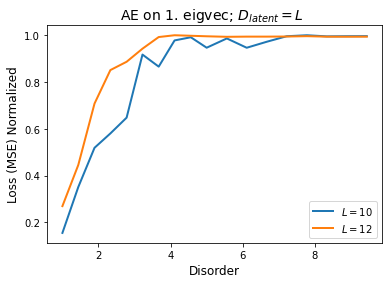

In [154]:
#ws12_42 =ws
#min_val_loss_12_42 = min_val_loss


plt.plot(ws, np.array(min_val_loss)/max(min_val_loss), label = '$L=10$',
        lw=2)
plt.plot(ws, np.array(min_val_loss_12_42)/max(min_val_loss_12_42),
         label = '$L=12$', lw=2)
plt.title('AE on 1. eigvec; $D_{latent}=L$  ', fontsize=14)
plt.xlabel('Disorder', fontsize=12)
plt.ylabel('Loss (MSE) Normalized', fontsize=12)
plt.legend()
plt.savefig('NEW_AE_D_is_L10_12_S60_first.png', dpi=500, bbox_inches='tight')